In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sksurv.preprocessing import OneHotEncoder as SurvOneHotEncoder
from sksurv.util import Surv

from sksurv.column import encode_categorical
from sksurv.column import standardize
from sklearn.model_selection import train_test_split

from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
    brier_score
)

pd.set_option('display.max_rows', 500)

In [2]:
# pickle_file = 'data/COX_DATA_FULL_DECEASED_EXPERIMENTAL.pkl'
# pickle_file = 'data/DATA_DECEASED.pkl'
pickle_file = 'data/DATA_DECEASED_ex.pkl'

with open(pickle_file, 'rb') as f:
    dataset = pickle.load(f)

In [3]:
dataset.to_csv('data/DATA_DECEASED_ex.csv', index=False)

In [4]:
numeric_features = [
    "AGE",
    "BMI_CALC",
    "AGE_DON",
    "CREAT_TRR",
    "NPKID",
    "COLD_ISCH_KI",
    "DIALYSIS_TIME",
    "KDPI",
]
categorical_features = [
    "ON_DIALYSIS",
    "PRE_TX_TXFUS",
    "GENDER",
    "ETHCAT",
    "DIABETES_DON",
    "DIAB",
    "HCV_SEROSTATUS",
]


In [5]:

def preprocess_data(feature_importance):
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('encoder', OneHotEncoder(handle_unknown='ignore')) # maybe it's better to use not ignore
    ])
    preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)
            ]
        )

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor)
    ])

    if feature_importance:
        categorical_x = encode_categorical(dataset[categorical_features])
        numerical_x = standardize(dataset[numeric_features])
        X = pd.concat([numerical_x, categorical_x], axis=1)
    else:
        X = pipeline.fit_transform(dataset[categorical_features + numeric_features])
    
    survival_time = dataset["PTIME"].astype(np.float64)
    event = dataset["PSTATUS"].astype(float).astype(bool)
    y = Surv.from_arrays(event, survival_time, "Status", "Days")

    return X, y


X, y = preprocess_data(True)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y["Status"], random_state=42)

In [7]:
X_train.head()

,AGE,BMI_CALC,AGE_DON,CREAT_TRR,NPKID,COLD_ISCH_KI,DIALYSIS_TIME,KDPI,ON_DIALYSIS=Y,PRE_TX_TXFUS=Y,...,ETHCAT=6,ETHCAT=7,DIABETES_DON=Y,DIAB=2.0,DIAB=3.0,DIAB=4.0,DIAB=5.0,DIAB=998.0,HCV_SEROSTATUS=ND,HCV_SEROSTATUS=P
__null_dask_index__,,,,,,,,,,,,,,,,,,,,,
168,1.456985,-0.751101,1.201540,-0.575300,-0.337364,1.384782,-0.913116,1.383906,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
310,-0.451411,-1.101481,-0.848389,-1.114998,2.435534,-1.609925,-0.715460,-1.396717,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
238,-0.298739,-1.470303,0.417744,1.583495,2.435534,3.226055,0.234130,0.197507,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
497,0.922634,-0.751101,-0.908681,-1.299632,-0.337364,0.486926,0.091986,-0.581068,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
308,-0.146067,1.185214,1.020664,1.753926,-0.337364,0.925853,-0.082119,1.569281,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
def evaluate_model_uno_c(model, test_X, test_y, train_y, times):
    pred = model.predict(test_X)
    uno_concordance = concordance_index_ipcw(train_y, test_y, pred, tau=times[-1])
    return uno_concordance

def evaluate_model(model, test_X, test_y, train_y, times):
    pred = model.predict(test_X)
    surv_fn = model.predict_survival_function(test_X, return_array=False)
    surv_prob = np.row_stack([fn(times) for fn in surv_fn])

    uno_concordance = concordance_index_ipcw(train_y, test_y, pred, tau=times[-1])
    ibs = integrated_brier_score(train_y, test_y, surv_prob, times)
    auc, mean_auc = cumulative_dynamic_auc(train_y, test_y, pred, times)

    print(f"Concordance Uno: {round(uno_concordance[0], 3)}")
    print(f"IBS: {round(ibs, 3)}")
    print(f"Mean AUC: {round(mean_auc,3)}")

    return uno_concordance, ibs, mean_auc

In [9]:
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sklearn.model_selection import KFold, GridSearchCV

lower, upper = np.percentile(y["Days"], [10, 90])
times = np.arange(lower, upper + 1)

cox = CoxnetSurvivalAnalysis(l1_ratio=0.9, max_iter=1000)
cox.fit(X_train, y_train)

estimated_alphas = cox.alphas_

cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    CoxnetSurvivalAnalysis(l1_ratio=0.9),
    param_grid={"alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=-1,
).fit(X_train, y_train)

cv_results = pd.DataFrame(gcv.cv_results_)

/Users/kyrylo/anaconda3/envs/kidney-life/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:729: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
/Users/kyrylo/anaconda3/envs/kidney-life/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:729: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)


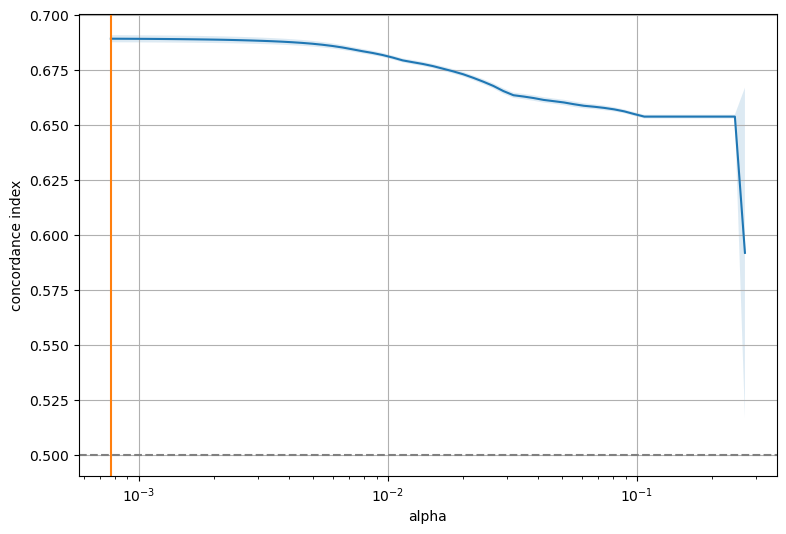

In [10]:
import matplotlib.pyplot as plt

alphas = cv_results.param_alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

In [11]:
best_params = gcv.best_params_

coxnet_pred = CoxnetSurvivalAnalysis(l1_ratio=0.9, alphas=[best_params['alphas'][0]], fit_baseline_model=True)
coxnet_pred.fit(X_train, y_train)
_,_,_ = evaluate_model(coxnet_pred, X_test, y_test, y_train, times)

Concordance Uno: 0.695
IBS: 0.163
Mean AUC: 0.73


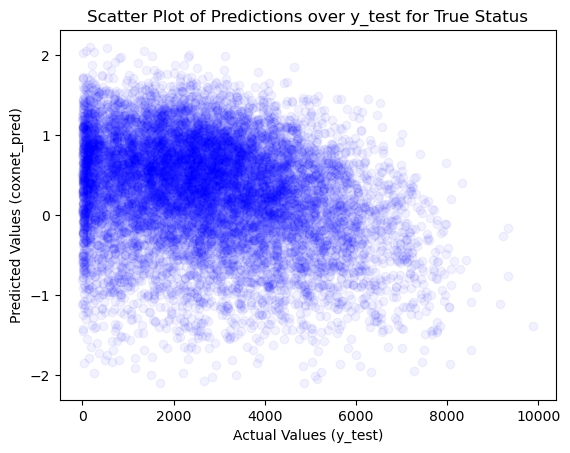

In [16]:
import matplotlib.pyplot as plt

prediction = coxnet_pred.predict(X_test, alpha=[best_params['alphas'][0]])

true_data = y_test[y_test['Status']]

# Extract the "Days" and "Prediction" values from the filtered data
days_true = true_data['Days']
prediction_true = prediction[y_test['Status']]

# Plot the filtered data
plt.scatter(days_true, prediction_true, color='blue', alpha=0.05)
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (coxnet_pred)')
plt.title('Scatter Plot of Predictions over y_test for True Status')
plt.show()

In [18]:
import pandas as pd

# Assuming y_test[Days] and prediction are numpy arrays
df = pd.DataFrame({'y_test[Days]': days_true, 'prediction': prediction_true})

df_sorted = df.sort_values(by='prediction')
df_sorted

,y_test[Days],prediction
4390,1694.0,-2.095272
3367,4852.0,-2.094851
1997,2670.0,-2.072616
4003,5144.0,-2.052362
9676,2840.0,-2.021788
...,...,...
8726,245.0,2.041215
3231,1340.0,2.048483
11248,83.0,2.056754
1700,532.0,2.088273


In [19]:
df_sorted.corr()

,y_test[Days],prediction
y_test[Days],1.000000,-0.261867
prediction,-0.261867,1.000000


Number of non-zero coefficients: 19


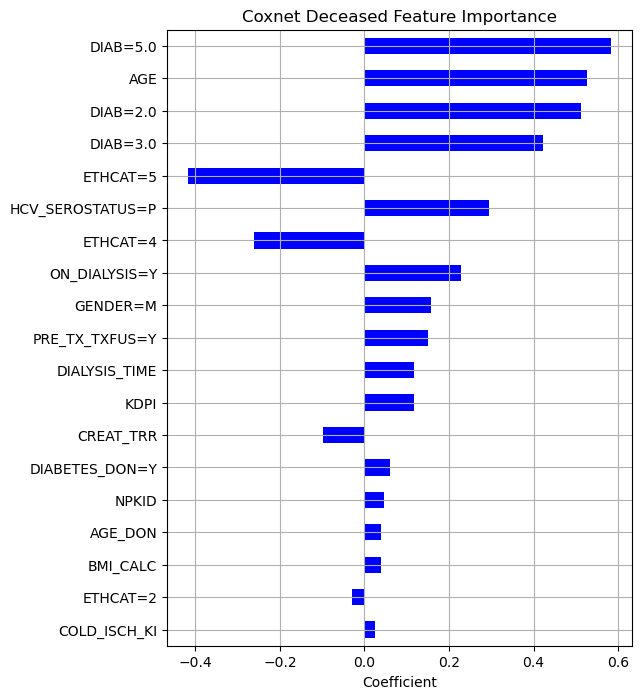

In [13]:
# Visual demonstration of feature importance. Uncomment if features weren't processed with pipeline

best_model = gcv.best_estimator_
best_coefs = pd.DataFrame(best_model.coef_, index=X.columns, columns=["coefficient"])

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print(f"Number of non-zero coefficients: {non_zero}")

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False, color='blue')
ax.set_xlabel("Coefficient")
ax.set_title("Coxnet Deceased Feature Importance")
ax.grid(True)

In [14]:
import pickle

# with open('pickle/COXNET_DECEASED_MODEL.pickle', 'wb') as f:
#     pickle.dump(coxnet_pred, f)

# Model Evaluation

In [15]:
from surv_data_pipeline.estimator_evaluation import SurvivalEstimatorEvaluation
import matplotlib.pyplot as plt

# SurvivalEstimatorEvaluation.plot_time_dependent_auc(coxnet_pred, X_test, y_test, times)
def plot_time_dependent_auc(model, x_test, y_test, y_train, name=None):
    lower, upper = np.percentile(y_train["Days"], [10, 90])
    times = np.arange(lower, upper + 1)
    print("predicting....")
    cph_risk_scores = model.predict(x_test)
    print("calculating auc...")
    auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, cph_risk_scores, times)
    print("plotting inside...")
    plt.plot(times, auc, marker=",")
    plt.axhline(mean_auc, linestyle="--")
    # plt.text(5, 0, "{model}", fontsize=12)
    plt.xlabel("days")
    plt.ylabel("time-dependent AUC")
    plt.grid(True)
    if name is not None:
        plt.savefig(f"/mnt/lustre/helios-home/stadnkyr/AUC_results/{name}_MAUC_{mean_auc}.png")
    plt.show()

ModuleNotFoundError: No module named 'surv_data_pipeline.estimator_evaluation'

predicting....
calculating auc...
plotting inside...


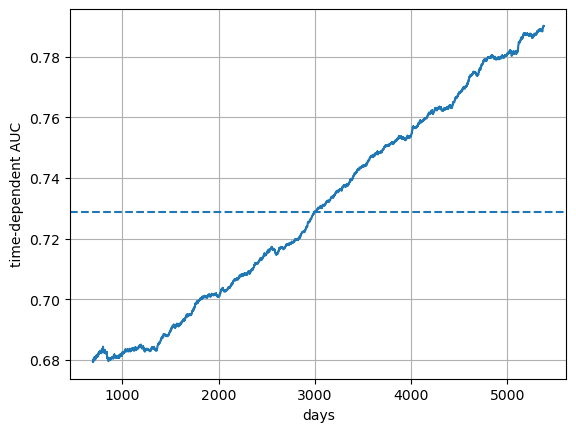

In [ ]:
plot_time_dependent_auc(coxnet_pred, X_test, y_test, y_train)

In [ ]:
surv_fn = coxnet_pred.predict_survival_function(X_test, return_array=False)

surv_prob = np.row_stack([fn(times) for fn in surv_fn])

bs = brier_score(y_train, y_test, surv_prob, times)
ibs = integrated_brier_score(y_train, y_test, surv_prob, times)#times)
print('Integrated Brier Score:', ibs)

Integrated Brier Score: 0.16348991091329643


Integrated Brier Score: 0.16520201404135063

Text(0, 0.5, 'time-dependent Brier Score')

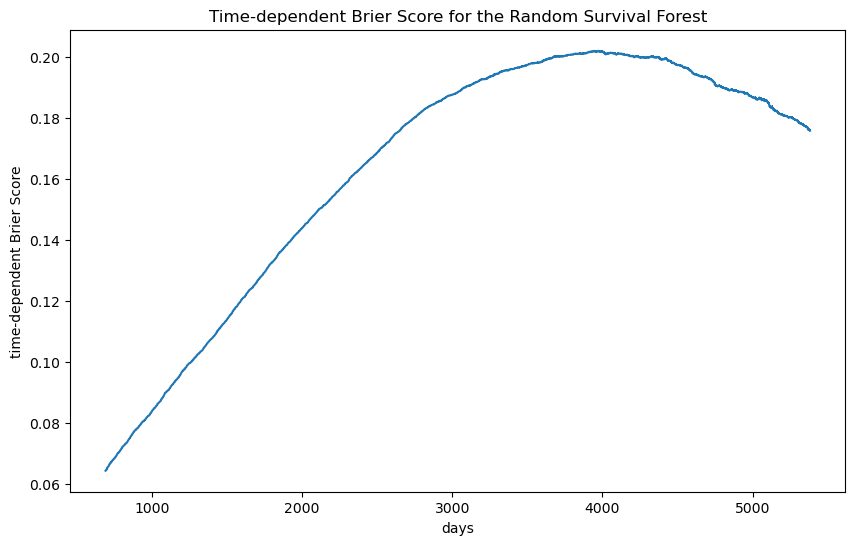

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10,6))
plt.plot(bs[0], bs[1], marker=",")
# plt.axhline(ibs, linestyle="--")
# plt.text(5, 0, "{model}", fontsize=12)
plt.title("Time-dependent Brier Score for the Random Survival Forest")
plt.xlabel("days")
plt.ylabel("time-dependent Brier Score")

In [ ]:
import pickle

with open('pickle/brier/BS_COXNET_DECEASED_FINAL.pickle', 'wb') as f:
    pickle.dump(bs, f)


In [ ]:
lower, upper = np.percentile(y_train["Days"], [10, 90])
times = np.arange(lower, upper + 1)
cph_risk_scores = coxnet_pred.predict(X_test)
auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, cph_risk_scores, times)


In [ ]:
import pickle

with open('pickle/AUC/AUC_COXNET_DECEASED_FINAL.pickle', 'wb') as f:
    pickle.dump((times, auc, mean_auc), f)

# Feature importance

In [ ]:
from sklearn.inspection import permutation_importance


# result = permutation_importance(coxnet_pred, X_test, y_test, n_repeats=10, random_state=0, n_jobs=1)

In [ ]:
pd.set_option('display.max_rows', 500)

columns = numeric_features + categorical_features

importances_df = pd.DataFrame(result.importances_mean, index=X.columns)
importances_df.columns = ['Importance']
importances_df.sort_values(by='Importance', ascending=False, inplace=True)

# Print out feature importances
importances_df

NameError: name 'result' is not defined